In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
import os
from lsst.utils import getPackageDir
import healpy as hp
import lsst.sims.photUtils as pu
from lsst.sims.utils import raDec2Hpid, healbin, hpid2RaDec

In [2]:
def iqr_sigma(in_array):
    iqr = np.percentile(in_array,75)-np.percentile(in_array,25)
    rms = iqr/1.349 #approximation
    return rms

def running_rms(x_points, y_points, bins=None, binsize=0.5):
    good_pts = ~np.isnan(y_points)
    if bins is None:
        bins = np.arange(np.min(x_points[good_pts]), np.max(x_points[good_pts])+binsize, binsize)
    result = bins*0.
    order = np.argsort(x_points[good_pts])
    inds = np.searchsorted(x_points[good_pts][order], bins[1:-1])
    
    result = np.array([iqr_sigma(group) for group in np.split(y_points[good_pts][order], inds)])
    return result, bins


In [3]:
data = np.load('Kurucz_models.npz')

stellar_fluxes = data['stellar_fluxes'].copy()
properties = data['properties'].copy()
wave = data['wave'].copy()
data.close()



In [4]:
stellar_fluxes.shape, wave.shape

((1100, 225), (225,))

In [5]:
throughPath = os.path.join(getPackageDir('throughputs'), 'baseline')
lsstKeys = ['u', 'g', 'r', 'i', 'z', 'y']
# lsstKeys = ['r']
bps = {}
for key in lsstKeys:
    bp = np.loadtxt(os.path.join(throughPath, 'total_'+key+'.dat'),
                    dtype=zip(['wave', 'trans'], [float]*2))
    bpTemp = Bandpass()
    good = np.where(bp['trans'] > 0.)
    bpTemp.setBandpass(bp['wave'], bp['trans'], wavelen_min=bp['wave'][good].min(),
                       wavelen_max=bp['wave'][good].max())
    bps[key] = bpTemp


In [6]:
names = ['u', 'g','r', 'i', 'z', 'y']
types = [float]*6
lsst_mags = np.zeros(stellar_fluxes.shape[0], dtype=list(zip(names, types)))


In [7]:
for i in np.arange(lsst_mags.size):
    sed = Sed(wavelen=wave, flambda=stellar_fluxes[i,:])
    for filtername in names:
        lsst_mags[filtername][i] = sed.calcMag(bps[filtername])

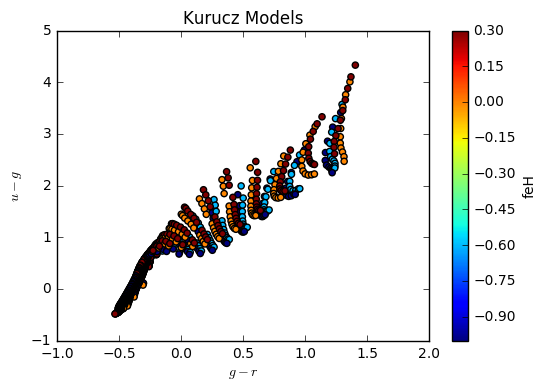

In [8]:
cprop = 'feH'
plt.scatter(lsst_mags['g']-lsst_mags['r'], lsst_mags['u']-lsst_mags['g'], c=properties[cprop])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
cb = plt.colorbar()
cb.set_label(cprop)
#plt.xlim([-.6, 0.])
plt.title('Kurucz Models')
plt.savefig('Plots/kuruz_met.png')

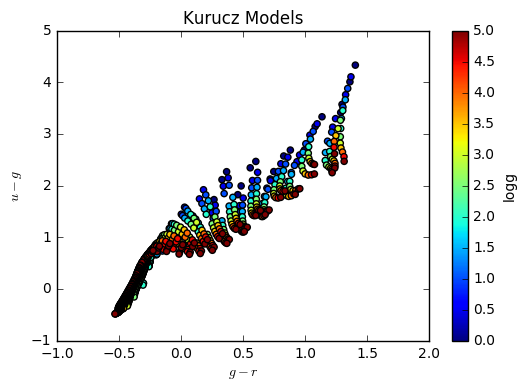

In [9]:
cprop = 'logg'
plt.scatter(lsst_mags['g']-lsst_mags['r'], lsst_mags['u']-lsst_mags['g'], c=properties[cprop])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
cb = plt.colorbar()
cb.set_label(cprop)
plt.title('Kurucz Models')

plt.savefig('Plots/kuruz_logg.png')

In [10]:
np.unique(properties['logg'])

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [11]:
# XXX--now, let's just say we have the observed Gaia mags, and the gaia fit paramters are perfect, good, or bad
# and see what the recovered u-band looks like?


In [12]:
ack = np.load('0_33578_gum_mag_cat.npz')
stars = ack['result_cat'].copy()
ack.close()

In [13]:
# initialize the stellar SED cache
ack = pu.read_close_Kurucz(6000., 0., 20.)


Opening cache of LSST SEDs in:
/Users/yoachim/gitRepos/sims_photutils/cacheDir/lsst_sed_cache_2.p


/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:1493: UserWarning: Multiple close files
  warnings.warn('Multiple close files')


In [14]:
# try to figure out what values were actually used
names = ['feH', 'logg','teff']
actual = np.zeros(stars.size, dtype=zip(names, [float]*3))


In [15]:
for i,star in enumerate(stars):
    temp_sed, temp_dict = pu.read_close_Kurucz(star['teff'], star['feH'], star['logg'])
    for key in actual.dtype.names:
        actual[key][i] = temp_dict[key]

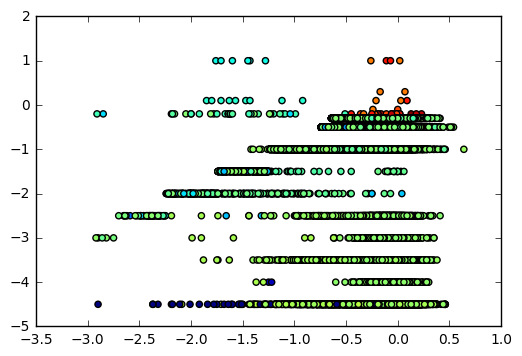

In [16]:
plt.scatter(stars['feH'], actual['feH'], c=stars['logg'])

In [17]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [18]:
# Let's make a simple polynomial model for fitting u-g given g-r, feH, and logg.
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [19]:
X = np.vstack((lsst_mags['g'] - lsst_mags['r'], properties['feH'], properties['logg']))
#X = np.vstack((properties['teff'], properties['feH'], properties['logg']))


In [20]:
model = model.fit(X.T,lsst_mags['u'] - lsst_mags['g'])

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


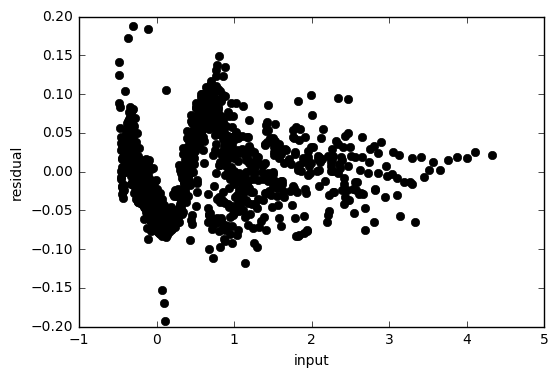

In [21]:
check = model.predict(X.T)
plt.plot(lsst_mags['u'] - lsst_mags['g'], (lsst_mags['u'] - lsst_mags['g']) - check, 'ko')
plt.xlabel('input')
plt.ylabel('residual')

In [22]:
# wow that sucks, let's try some scipy interpolation schemes
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

In [23]:
interp = LinearNDInterpolator(X.T,lsst_mags['u'] - lsst_mags['g'], rescale=True)

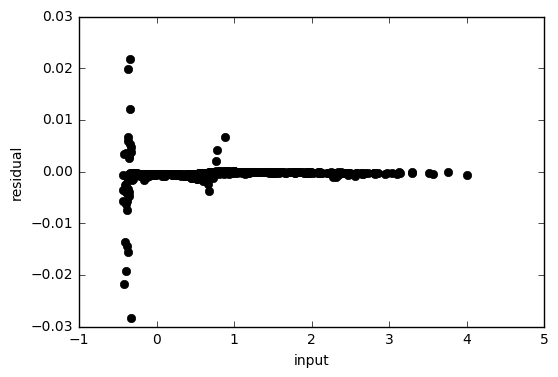

In [24]:
delta = .0001
check = interp(X.T+delta)
plt.plot(lsst_mags['u'] - lsst_mags['g'], (lsst_mags['u'] - lsst_mags['g']) - check, 'ko')
plt.xlabel('input')
plt.ylabel('residual')

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.0314261652567
0.0402319976835
990 110


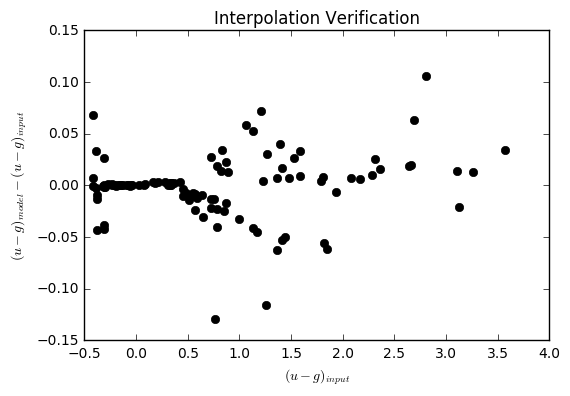

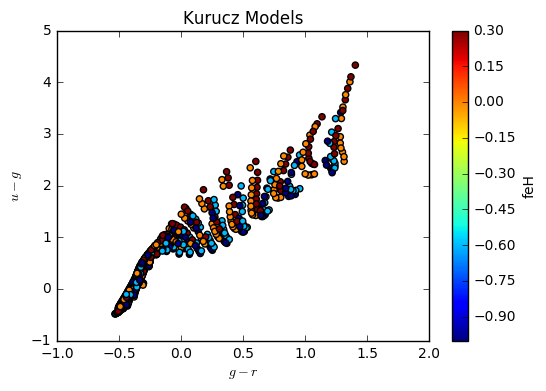

In [25]:
# Let's check that the interpolation works for points if they are held out
np.random.seed(seed=40)
ack = np.random.random(lsst_mags['u'].size)
order = np.argsort(ack)
ind1 = order[0:order.size*.9]
ind2 = order[order.size*.9:]
interp_half = LinearNDInterpolator(X.T[ind1],lsst_mags['u'][ind1] - lsst_mags['g'][ind1], rescale=True)
check_u_g = interp_half(X.T[ind2])
real_u_g = lsst_mags['u'][ind2] - lsst_mags['g'][ind2]
plt.figure()
plt.plot(real_u_g, check_u_g-real_u_g, 'ko')
plt.xlabel(r'$(u-g)_{input}$')
plt.ylabel(r'$(u-g)_{model}-(u-g)_{input}$')
plt.title('Interpolation Verification')
plt.savefig('Plots/interp_verify.png')
residuals = check_u_g-real_u_g

plt.figure()
cprop='feH'
plt.scatter(lsst_mags['g'][ind1]-lsst_mags['r'][ind1], lsst_mags['u'][ind1]-lsst_mags['g'][ind1], c=properties[cprop][ind1])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
cb = plt.colorbar()
cb.set_label(cprop)
plt.title('Kurucz Models')


print np.std(residuals[np.isfinite(residuals)])
red = np.where((real_u_g > 0.5) & np.isfinite(residuals))
print np.std(residuals[red])
print np.size(ind1), np.size(ind2)

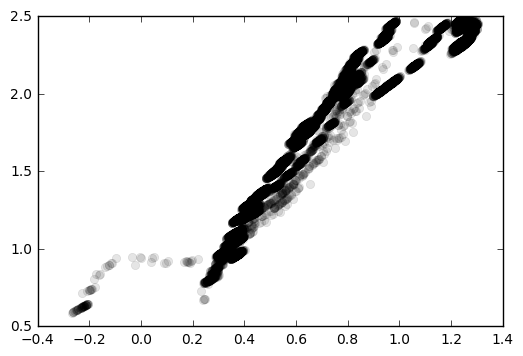

In [26]:
plt.plot(stars['g_true']-stars['r_true'], stars['u_true']-stars['g_true'], 'ko', alpha=.1)

In [27]:
check_u_g

array([-0.41295545, -0.07801192,  1.28125522, -0.4163602 ,  0.88887975,
       -0.34534616,  2.75019546, -0.38722825, -0.15333722,  0.57428263,
        0.28639657, -0.21056632,  0.17066192, -0.12302408, -0.42502645,
        0.83252991,  0.85007832,  0.8306198 ,  0.53134081,  0.74903362,
        0.34234715,  1.18733032,  1.79765889, -0.3480388 ,  0.21586597,
        2.33689523,  2.65590022,  0.32844295,  0.44042647,  1.61763613,
        0.49874663,  0.96571278, -0.23135304,  1.92887414,  0.42409569,
        0.32721758,  1.37077609,  2.08723589,  3.10851683,  1.59077618,
        0.709677  ,  0.36765974,  1.78202779,  3.60400744,  1.76319818,
       -0.30461836,  1.39214839,  0.74375339,  0.74093634, -0.30160704,
       -0.35032466,  1.36372275,  1.8148935 ,  2.67951429,  0.76221517,
        0.55771332,  1.14155039, -0.14658981,  1.29826605, -0.30734657,
       -0.19452903, -0.23294853,  0.62554273,  0.47813769,  1.43367362,
        3.11756824,  3.27575815, -0.16331436,  0.0766979 ,  2.17

In [28]:
# Make a correction so now only the random noise is left.
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    diff = stars[fn+'_noiseless']-stars[fn+'_true']
    stars[fn] -= diff

In [29]:
# XXX--ok, that looks like I can drop in measured values and get reasonable outputs.
X = np.vstack((stars['g_true']-stars['r_true'], stars['feH'], stars['logg'])).T
new_u = interp(X) + stars['g_true']

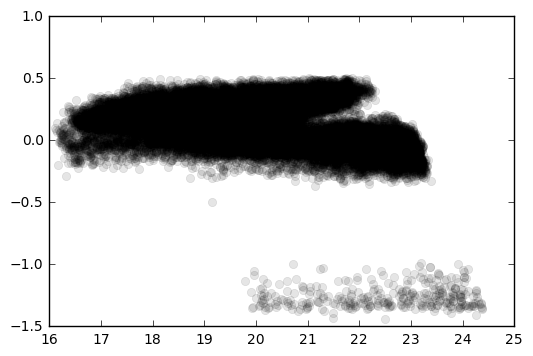

In [30]:
plt.plot(new_u, stars['u_true']-new_u, 'ko', alpha=.1)

In [31]:

mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps')
data = np.load(os.path.join(mapDir,'starDensity_%s_nside_64.npz' % 'u'))
starDensity = data['starDensity'].copy()
# magnitude bins 
hp_bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask']
data.close()
nside = hp.npix2nside(starDensity[:,0].size)

In [32]:
def hp_downgrade(mapin, nside_out=32):
    """
    Let's average down the stellar density maps
    """
    nside_in = hp.npix2nside(np.size(mapin))
    hpid_in = np.arange(np.size(mapin))
    ra, dec = hpid2RaDec(nside_in, hpid_in)
    
    new_map = healbin(ra, dec, mapin, nside=nside_out, reduceFunc=np.mean)
    return new_map
    

In [33]:
def area_needed_plot(mags, resids, starDensity=None, title='', max=10000):
    # Now to 
    f_o_v_sq_deg = 3.0e9*0.2**2/(60.**2)/(60.**2)
    goal_err = 0.01
    mag_range = [16., 18.]
    # find the area needed to get to the goal area
    fn = 'u'
    running, bins = running_rms(mags,  resids)
    n_stars, bins = np.histogram(mags, bins=bins)
    gbins = np.where((bins >= np.min(mag_range)) & (bins <= np.max(mag_range)))[0]
    err_sq = running[gbins]**2/n_stars[gbins]
    frac_stars_needed = 1./np.sum(n_stars[gbins]/running[gbins]**2)/goal_err**2
    area_needed_sq_arcmin = f_o_v_sq_deg*frac_stars_needed * 60.**2
    
    
    
    ra_gums = stars['raj2000'].mean()
    dec_gums = stars['dej2000'].mean()
    gums_hp = raDec2Hpid(nside, ra_gums, dec_gums)
    
    gbins = np.where((hp_bins >= np.min(mag_range)) & (hp_bins <= np.max(mag_range)))[0]
    starDensity = starDensity[:,np.max(gbins)] - starDensity[:,np.min(gbins)]
    print 'billions of stars in filter %s = %f' % (fn, 1e-9*np.sum(starDensity*hp.nside2pixarea(nside, degrees=True)))
    gums_density = starDensity[gums_hp]
    
    starDensity = hp_downgrade(starDensity)
    area_needed_map = area_needed_sq_arcmin/starDensity*gums_density
    hp.mollview(area_needed_map, unit='sq arcmin', title=fn+' '+title, min=1, max=max)
    
    plt.savefig('Plots/area_needed_%s.png' % title)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide


0.00563079515502 -7.15269136613e-05
billions of stars in filter u = 0.037939


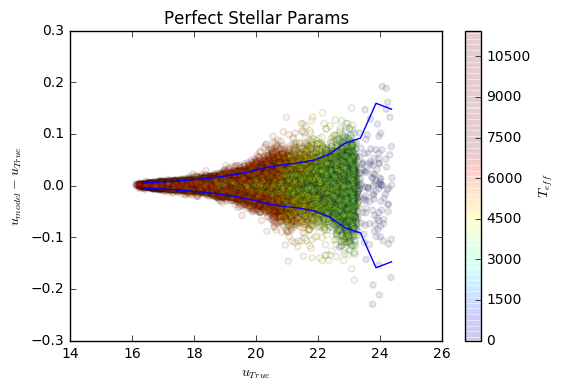

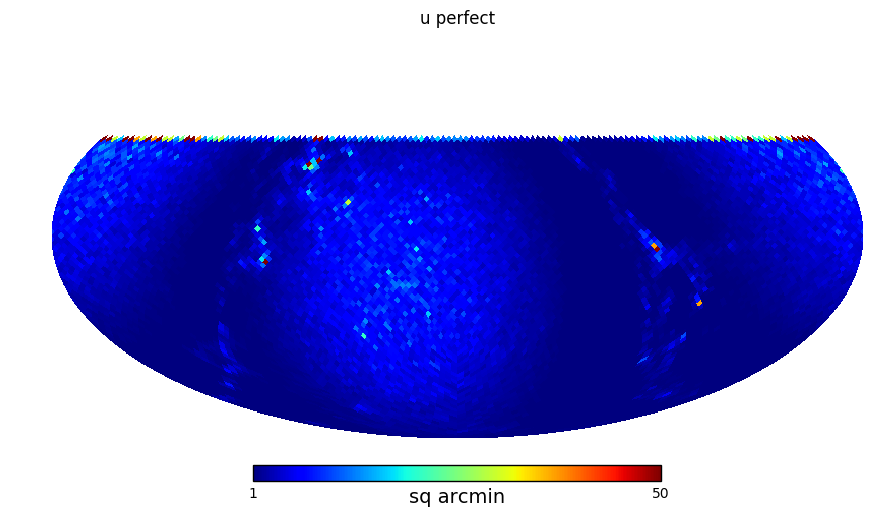

In [34]:
# If we have perfect metallicities and logg from Gaia
X = np.vstack((stars['g']-stars['r'], stars['feH'], stars['logg'])).T
u_perfect_met = interp(X) + stars['g']

plt.scatter(new_u, u_perfect_met-new_u, c=stars['teff'], alpha=.1)
fn = 'u'
plt.xlabel(r'$%s_{True}$' % fn)
plt.ylabel(r'$%s_{model} - %s_{True}$' % (fn, fn))

cb = plt.colorbar()
cb.set_clim([0, 7000])
cb.set_label(r'$T_{eff}$')

running, bins = running_rms(new_u, u_perfect_met-new_u)
plt.plot((bins[:-1]+bins[1:])/2., 2.*running, 'b')
plt.plot((bins[:-1]+bins[1:])/2., -2*running, 'b')

plt.title('Perfect Stellar Params')

plt.savefig('Plots/u_perfect.png')

good = np.where( (new_u > 17.8) & (new_u < 18.2))
print np.std(u_perfect_met[good]-new_u[good]), np.median(u_perfect_met[good]-new_u[good])

good = ~np.isnan(new_u)
area_needed_plot(new_u[good], u_perfect_met[good]-new_u[good], starDensity=starDensity, title='perfect', max=50)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide


0.0084829027368 0.000282376919326
billions of stars in filter u = 0.037939


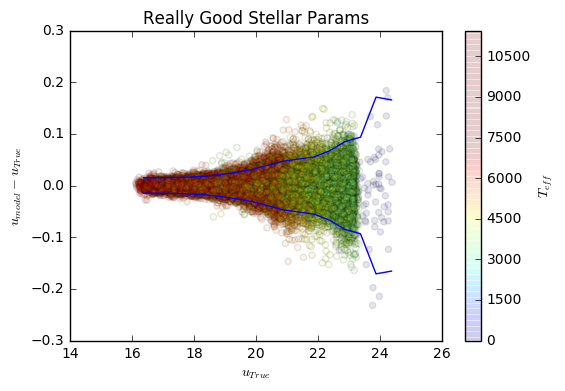

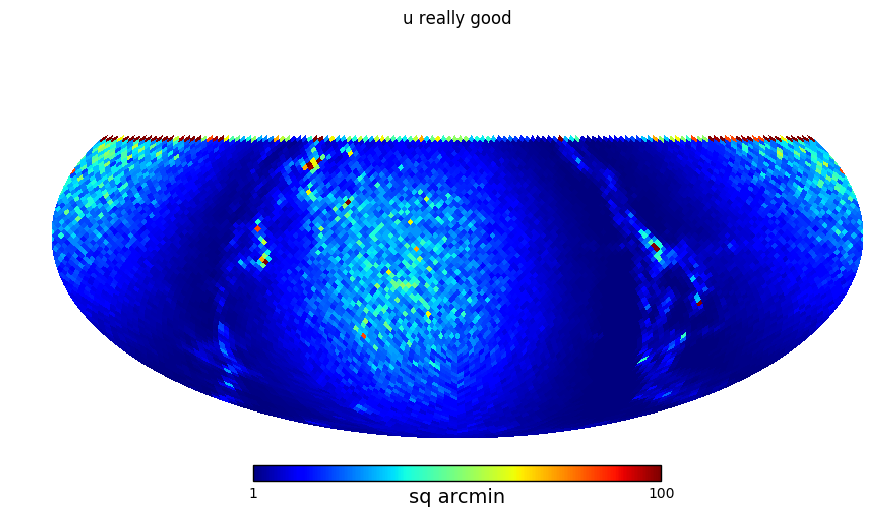

In [35]:
feh_noise = 0.03*np.random.normal(size=stars.size)
logg_noise = 0.02*np.random.normal(size=stars.size)
X = np.vstack((stars['g']-stars['r'], stars['feH']+feh_noise, stars['logg']+logg_noise)).T
u_good_met = interp(X) + stars['g']

plt.scatter(new_u, u_good_met-new_u, c=stars['teff'], alpha=.1)
fn = 'u'
plt.xlabel(r'$%s_{True}$' % fn)
plt.ylabel(r'$%s_{model} - %s_{True}$' % (fn, fn))


running, bins = running_rms(new_u,  u_good_met-new_u)
plt.plot((bins[:-1]+bins[1:])/2., 2.*running, 'b')
plt.plot((bins[:-1]+bins[1:])/2., -2*running, 'b')

cb = plt.colorbar()
cb.set_clim([0, 7000])
cb.set_label(r'$T_{eff}$')

plt.title('Really Good Stellar Params')
plt.savefig('Plots/u_really_good.png')
good = np.where( (new_u > 17.8) & (new_u < 18.2) & (~np.isnan(u_good_met)))
print np.std(u_good_met[good]-new_u[good]), np.median(u_good_met[good]-new_u[good])


good = ~np.isnan(new_u)
area_needed_plot(new_u[good], u_good_met[good]-new_u[good], starDensity=starDensity, title='really good', max=100)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide


0.0256436865345 0.00114197523498
billions of stars in filter u = 0.037939


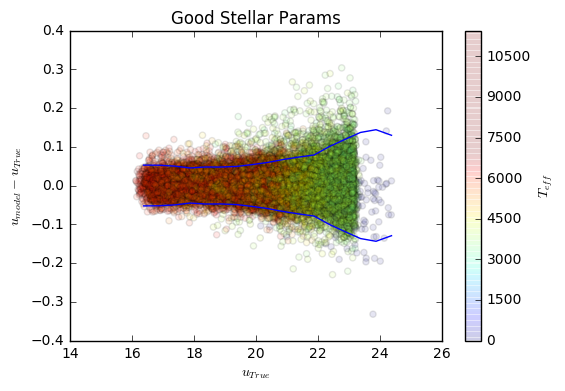

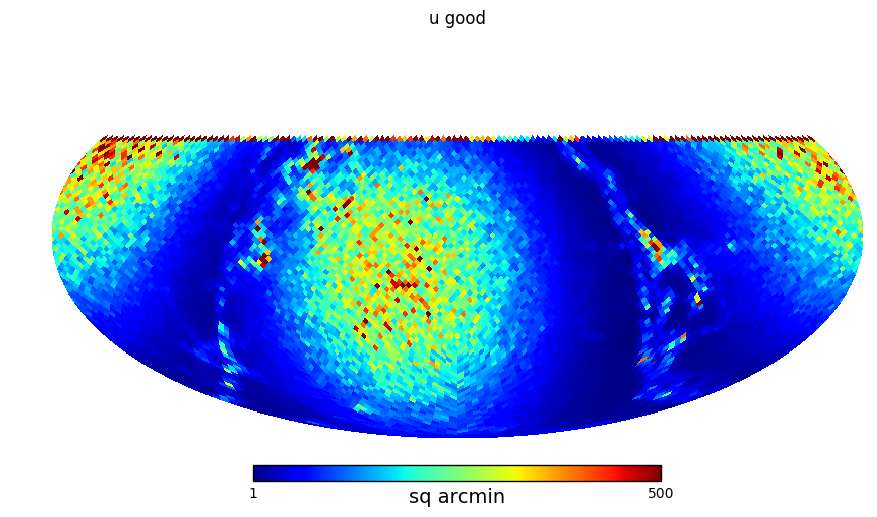

In [36]:
feh_noise = 0.1*np.random.normal(size=stars.size)
logg_noise = 0.2*np.random.normal(size=stars.size)
X = np.vstack((stars['g']-stars['r'], stars['feH']+feh_noise, stars['logg']+logg_noise)).T
u_good_met = interp(X) + stars['g']

plt.scatter(new_u, u_good_met-new_u, c=stars['teff'], alpha=.1)
fn = 'u'
plt.xlabel(r'$%s_{True}$' % fn)
plt.ylabel(r'$%s_{model} - %s_{True}$' % (fn, fn))


running, bins = running_rms(new_u,  u_good_met-new_u)
plt.plot((bins[:-1]+bins[1:])/2., 2.*running, 'b')
plt.plot((bins[:-1]+bins[1:])/2., -2*running, 'b')

cb = plt.colorbar()
cb.set_clim([0, 7000])
cb.set_label(r'$T_{eff}$')

plt.title('Good Stellar Params')
plt.savefig('Plots/u_good.png')
good = np.where( (new_u > 17.8) & (new_u < 18.2) & (~np.isnan(u_good_met)))
print np.std(u_good_met[good]-new_u[good]), np.median(u_good_met[good]-new_u[good])


good = ~np.isnan(new_u)
area_needed_plot(new_u[good], u_good_met[good]-new_u[good], starDensity=starDensity, title='good', max=500)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in greater
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less


0.0655942662613 0.00547088574462


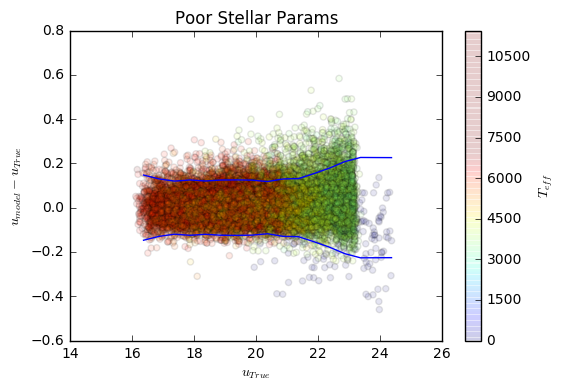

In [37]:
feh_noise = 0.3*np.random.normal(size=stars.size)
logg_noise = 0.5*np.random.normal(size=stars.size)
X = np.vstack((stars['g']-stars['r'], stars['feH']+feh_noise, stars['logg']+logg_noise)).T
u_good_met = interp(X) + stars['g']

plt.scatter(new_u, u_good_met-new_u, c=stars['teff'], alpha=.1)
fn = 'u'
plt.xlabel(r'$%s_{True}$' % fn)
plt.ylabel(r'$%s_{model} - %s_{True}$' % (fn, fn))
plt.title(r'Poor Stellar Params')

running, bins = running_rms(new_u,  u_good_met-new_u)
plt.plot((bins[:-1]+bins[1:])/2., 2.*running, 'b')
plt.plot((bins[:-1]+bins[1:])/2., -2*running, 'b')


cb = plt.colorbar()
cb.set_clim([0, 7000])
cb.set_label(r'$T_{eff}$')
plt.savefig('Plots/u_poor.png')
good = np.where( (new_u > 17.8) & (new_u < 18.2) & (~np.isnan(u_good_met)))
print np.std(u_good_met[good]-new_u[good]), np.median(u_good_met[good]-new_u[good])

billions of stars in filter u = 0.037939


/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide


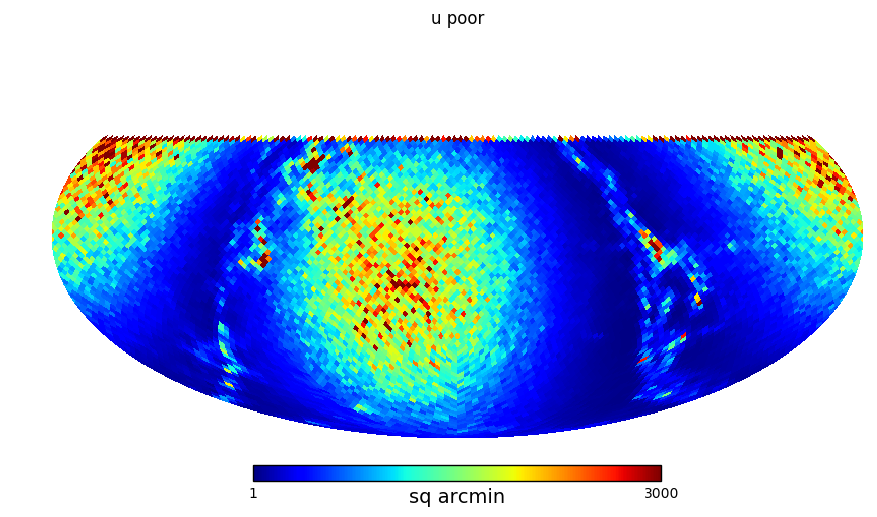

In [38]:



    
good = ~np.isnan(new_u)
area_needed_plot(new_u[good], u_good_met[good]-new_u[good], starDensity=starDensity, title='poor', max=3000)